In [ ]:
import pandas as pd
from google.colab import files

def load_upi_fraud_data(filename="upi_fraud_transactions.csv"):
    """
    Uploads and loads the UPI fraud dataset into a pandas DataFrame.
    """
    uploaded = files.upload()

    if filename not in uploaded:
        raise FileNotFoundError(f"{filename} not found. Please upload the correct CSV file.")

    df = pd.read_csv(filename)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
    return df


In [ ]:
df = load_upi_fraud_data(filename="upi_fraud_transactions.csv")
df.head()

Saving upi_fraud_transactions.csv to upi_fraud_transactions.csv
Dataset loaded successfully.
Shape: (20000, 9)


,txn_id,user_id,merchant_id,txn_time,amount,device_type,location_id,txn_type,is_fraud
0,0,1127,123,19727,160.50,Android,2,P2P,0
1,1,1460,227,23665,2.17,Android,74,P2P,0
2,2,861,390,31126,535.48,iOS,39,P2P,0
3,3,1295,444,19481,2111.76,Android,99,P2M,0
4,4,1131,301,25836,264.46,Android,33,P2P,0


In [ ]:
def basic_data_checks(df):
    print("---- BASIC INFO ----")
    display(df.info())

    print("\n---- MISSING VALUES ----")
    display(df.isnull().sum())

    print("\n---- CLASS DISTRIBUTION ----")
    display(df['is_fraud'].value_counts(normalize=True))

basic_data_checks(df)


---- BASIC INFO ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   txn_id       20000 non-null  int64  
 1   user_id      20000 non-null  int64  
 2   merchant_id  20000 non-null  int64  
 3   txn_time     20000 non-null  int64  
 4   amount       20000 non-null  float64
 5   device_type  20000 non-null  object 
 6   location_id  20000 non-null  int64  
 7   txn_type     20000 non-null  object 
 8   is_fraud     20000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 1.4+ MB


None


---- MISSING VALUES ----


,0
txn_id,0
user_id,0
merchant_id,0
txn_time,0
amount,0
device_type,0
location_id,0
txn_type,0
is_fraud,0



---- CLASS DISTRIBUTION ----


,proportion
is_fraud,
0,0.8697
1,0.1303


In [ ]:
fraud_rate=df['is_fraud'].mean()
print(f"Overall Fraud Rate: {fraud_rate:.2%}")

Overall Fraud Rate: 13.03%


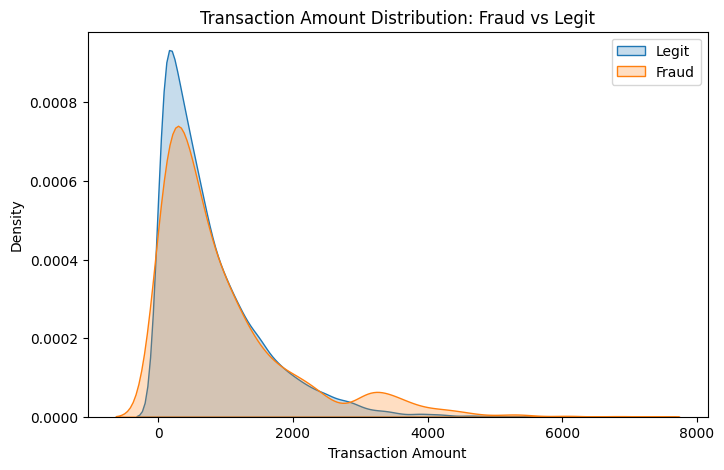

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(df[df.is_fraud==0]['amount'], label='Legit', fill=True)
sns.kdeplot(df[df.is_fraud==1]['amount'], label='Fraud', fill=True)
plt.xlabel("Transaction Amount")
plt.title("Transaction Amount Distribution: Fraud vs Legit")
plt.legend()
plt.show()


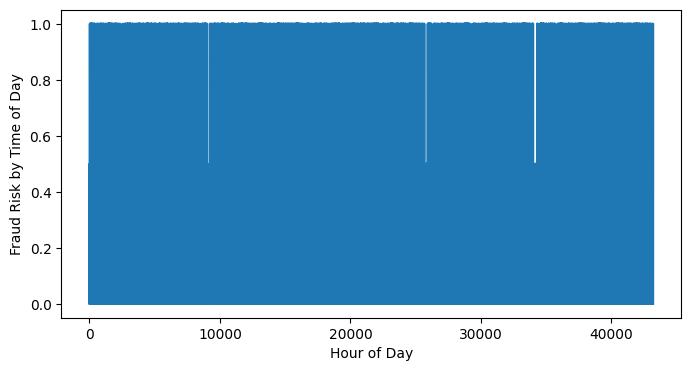

In [ ]:
fraud_by_hour=df.groupby('txn_time')['is_fraud'].mean()
plt.figure(figsize=(8,4))
fraud_by_hour.plot()
plt.xlabel("Hour of Day")
plt.ylabel('Fraud Risk by Time of Day')
plt.show()

In [ ]:
device_risk = df.groupby('device_type')['is_fraud'].mean().sort_values(ascending=False)
device_risk


,is_fraud
device_type,
Web,0.312228
iOS,0.110943
Android,0.108496


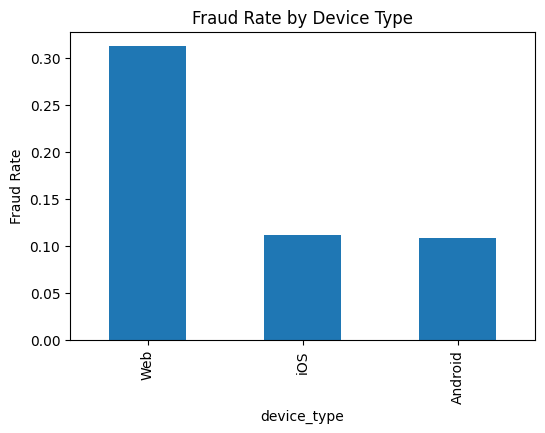

In [ ]:
plt.figure(figsize=(6,4))
device_risk.plot(kind='bar')
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Device Type")
plt.show()


In [ ]:
txn_type_risk=df.groupby('txn_type')['is_fraud'].mean().sort_values(ascending=False)
txn_type_risk

,is_fraud
txn_type,
P2M,0.223005
P2P,0.067406
BillPay,0.066633


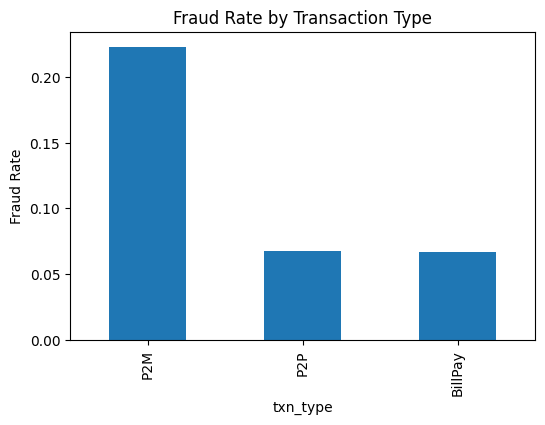

In [ ]:
plt.figure(figsize=(6,4))
txn_type_risk.plot(kind='bar')
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Transaction Type")
plt.show()


In [ ]:
location_risk = df.groupby('location_id')['is_fraud'].mean()

high_risk_locations = location_risk[location_risk > location_risk.mean() + 2*location_risk.std()]
high_risk_locations.head()


,is_fraud
location_id,
3,0.188482
72,0.197183


In [ ]:
#Number of transactions per user
user_txn_count=df.groupby('user_id')['txn_id'].transform('count')
df['user_txn_count']=user_txn_count

In [ ]:
user_avg_amount = df.groupby('user_id')['amount'].transform('mean')
user_std_amount = df.groupby('user_id')['amount'].transform('std').fillna(1)

df['amount_deviation'] = (df['amount'] - user_avg_amount) / user_std_amount


In [ ]:
merchant_fraud_rate = df.groupby('merchant_id')['is_fraud'].mean()
df['merchant_risk'] = df['merchant_id'].map(merchant_fraud_rate)


In [ ]:
merchant_fraud_rate = df.groupby('merchant_id')['is_fraud'].mean()
df['merchant_risk'] = df['merchant_id'].map(merchant_fraud_rate)


In [ ]:
import numpy as np

location_counts = df.groupby(['user_id', 'location_id']).size().reset_index(name='count')
total_counts = location_counts.groupby('user_id')['count'].transform('sum')
location_counts['prob'] = location_counts['count'] / total_counts

entropy = location_counts.groupby('user_id')['prob'].apply(
    lambda p: -np.sum(p * np.log(p + 1e-6))
)

df['location_entropy'] = df['user_id'].map(entropy)

In [ ]:
device_count = df.groupby('user_id')['device_type'].nunique()
df['device_switching'] = df['user_id'].map(device_count)


In [ ]:
df_encoded = pd.get_dummies(
    df,
    columns=['device_type', 'txn_type'],
    drop_first=True
)


In [ ]:
feature_cols = [
    'amount',
    'txn_time',
    'user_txn_count',
    'amount_deviation',
    'merchant_risk',
    'location_entropy',
    'device_switching'
] + [col for col in df_encoded.columns if col.startswith(('device_type_', 'txn_type_'))]

X = df_encoded[feature_cols]
y = df_encoded['is_fraud']


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(
    X,y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

log_model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
log_probs = log_model.predict_proba(X_test)[:, 1]


In [ ]:
from sklearn.metrics import roc_auc_score

roc_log = roc_auc_score(y_test, log_probs)
print("Logistic Regression ROC-AUC:", roc_log)


Logistic Regression ROC-AUC: 0.7722516149518279


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, log_probs)
pr_auc_log = auc(recall, precision)

print("Logistic Regression PR-AUC:", pr_auc_log)


Logistic Regression PR-AUC: 0.3341421230798492


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=200,
                       random_state=42)

In [ ]:
rf_probs = rf_model.predict_proba(X_test)[:, 1]


In [ ]:
roc_rf = roc_auc_score(y_test, rf_probs)
print("Random Forest ROC-AUC:", roc_rf)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_probs)
pr_auc_rf = auc(recall_rf, precision_rf)

print("Random Forest PR-AUC:", pr_auc_rf)


Random Forest ROC-AUC: 0.7793118745803456
Random Forest PR-AUC: 0.34122926481972027


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, rf_probs)

# Find threshold where FPR ≤ 1%
idx = np.where(fpr <= 0.01)[0][-1]

recall_at_1pct_fpr = tpr[idx]
print("Recall @ 1% FPR:", recall_at_1pct_fpr)


Recall @ 1% FPR: 0.06758832565284179


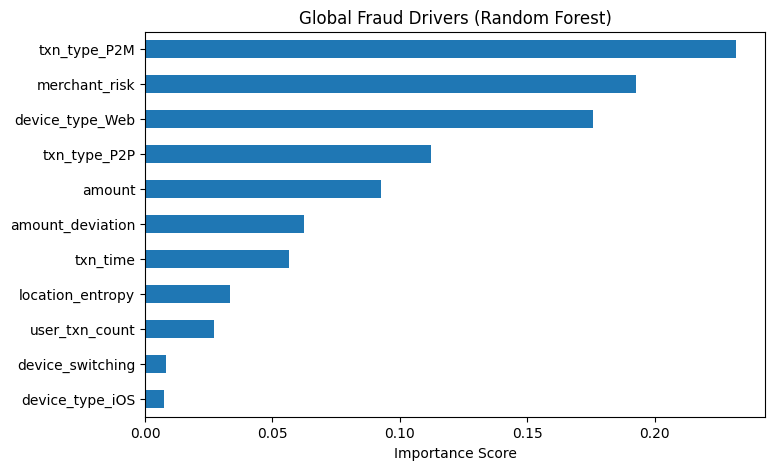

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=True)

plt.figure(figsize=(8,5))
feature_importance.plot(kind="barh")
plt.title("Global Fraud Drivers (Random Forest)")
plt.xlabel("Importance Score")
plt.show()


In [ ]:
df_test = X_test.copy()
df_test["fraud_prob"] = rf_probs
df_test["actual_label"] = y_test.values

# Top high-risk transactions
top_frauds = df_test.sort_values("fraud_prob", ascending=False).head(10)
top_frauds


,amount,txn_time,user_txn_count,amount_deviation,merchant_risk,location_entropy,device_switching,device_type_Web,device_type_iOS,txn_type_P2M,txn_type_P2P,fraud_prob,actual_label
13924,235.00,31849,8,-0.784803,0.245283,2.079434,3,True,False,True,False,0.874029,1
19224,241.77,24879,14,-0.861808,0.238095,2.441003,3,True,False,True,False,0.873949,1
18798,3076.68,20867,8,2.227621,0.208333,2.079434,3,False,False,True,False,0.872978,1
4445,196.62,25944,13,-1.157439,0.281250,2.458299,3,True,False,True,False,0.868512,1
9447,934.29,17900,8,-0.180615,0.243243,2.079434,3,True,False,True,False,0.862605,0
11699,611.01,19834,13,-0.204017,0.214286,2.564936,3,True,False,True,False,0.859455,0
4265,377.85,22953,10,-0.612035,0.333333,2.302575,3,True,False,True,False,0.858550,1
4697,297.64,13044,7,-0.804049,0.243902,1.945903,3,True,False,True,False,0.858262,1
7546,160.01,5678,8,-1.003122,0.241379,2.079434,3,True,False,True,False,0.855384,1
14111,620.69,16552,15,-0.324449,0.235294,2.615617,3,True,False,True,False,0.855082,1


In [ ]:
def rule_based_flags(row):
    flags = 0
    if row["amount"] > 50000:
        flags += 1
    if row["txn_time"] < 5: # Changed 'txn_hour' to 'txn_time'
        flags += 1
    if row["device_type_Web"] == 1: # Changed 'device_type_mobile' to 'device_type_Web' for non-mobile devices
        flags += 1
    return flags

df_test["rule_flags"] = df_test.apply(rule_based_flags, axis=1)

In [ ]:
def risk_bucket(p):
    if p > 0.8:
        return "High Risk"
    elif p > 0.4:
        return "Medium Risk"
    else:
        return "Low Risk"

df_test["risk_bucket"] = df_test["fraud_prob"].apply(risk_bucket)
df_test["risk_bucket"].value_counts()


,count
risk_bucket,
Low Risk,2914
Medium Risk,2008
High Risk,78


In [ ]:
# Business costs (approximate, interview-friendly)
COST_FRAUD_MISSED = 5000     # Fraud went through
COST_FALSE_ALERT = 200      # Genuine txn blocked


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

thresholds = np.arange(0.05, 0.95, 0.05)
costs = []

for t in thresholds:
    preds = (rf_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    total_cost = (fn * COST_FRAUD_MISSED) + (fp * COST_FALSE_ALERT)
    costs.append(total_cost)


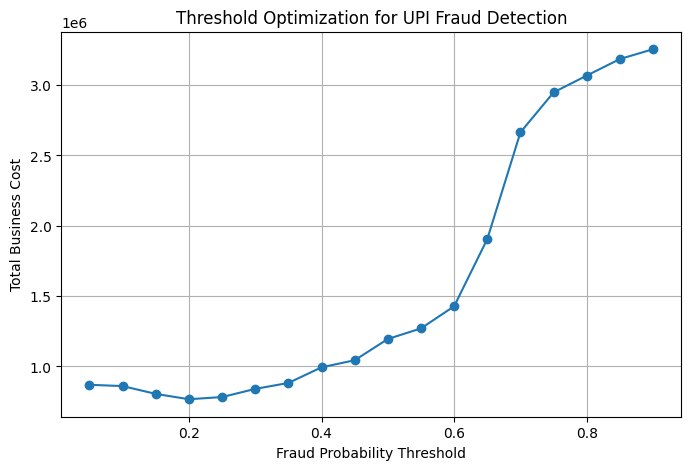

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(thresholds, costs, marker='o')
plt.xlabel("Fraud Probability Threshold")
plt.ylabel("Total Business Cost")
plt.title("Threshold Optimization for UPI Fraud Detection")
plt.grid(True)
plt.show()


In [ ]:
optimal_threshold = thresholds[np.argmin(costs)]
print(f"Optimal Fraud Threshold: {optimal_threshold}")



Optimal Fraud Threshold: 0.2


In [ ]:
def action_policy(row):
    if row["fraud_prob"] >= optimal_threshold:
        return "Block Transaction"
    elif row["fraud_prob"] >= 0.4:
        return "Step-up Authentication"
    else:
        return "Allow"

df_test["system_action"] = df_test.apply(action_policy, axis=1)
df_test["system_action"].value_counts()


,count
system_action,
Block Transaction,3759
Allow,1241


In [ ]:
# Sort by user and time
df = df.sort_values(["user_id", "txn_time"])

# Transaction count per user per hour
df["user_txn_count_1h"] = (
    df.groupby("user_id")["txn_time"]
      .transform(lambda x: x.diff().fillna(9999) < 3600)
      .groupby(df["user_id"]).cumsum()
)

# Rolling sum of amount (proxy)
df["user_amount_velocity"] = (
    df.groupby("user_id")["amount"]
      .rolling(5, min_periods=1)
      .sum()
      .reset_index(level=0, drop=True)
)


In [ ]:
merchant_risk = (
    df.groupby("merchant_id")["is_fraud"]
      .mean()
      .rename("merchant_fraud_rate")
)

df = df.merge(merchant_risk, on="merchant_id", how="left")


In [ ]:
from scipy.stats import entropy

def location_entropy(x):
    probs = x.value_counts(normalize=True)
    return entropy(probs)

loc_entropy = (
    df.groupby("user_id")["location_id"]
      .apply(location_entropy)
      .rename("location_entropy")
)

df = df.merge(loc_entropy, on="user_id", how="left")


In [ ]:
df["txn_hour"] = df["txn_time"] % 24

df["odd_hour_flag"] = df["txn_hour"].apply(
    lambda x: 1 if x < 5 else 0
)


In [ ]:
device_risk = {
    "Android": 0.1, # Assuming Android is a mobile device
    "iOS": 0.1,     # Assuming iOS is a mobile device
    "Web": 0.4,
    "unknown": 0.7
}

df["device_risk_score"] = df["device_type"].map(device_risk)

In [ ]:
from scipy.stats import entropy

def calculate_location_entropy(x):
    probs = x.value_counts(normalize=True)
    return entropy(probs)

# Ensure 'location_entropy' is in df
if 'location_entropy' not in df.columns:
    loc_entropy = (
        df.groupby("user_id")["location_id"]
          .apply(calculate_location_entropy)
          .rename("location_entropy")
    )
    df = df.merge(loc_entropy, on="user_id", how="left")

feature_cols = [
    "amount",
    "txn_hour",
    "odd_hour_flag",
    "user_amount_velocity",
    "merchant_fraud_rate",
    "location_entropy",
    "device_risk_score"
]

X = df[feature_cols]
y = df["is_fraud"]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_probs = rf_model.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))


ROC-AUC: 0.6933578437998432


In [ ]:
import numpy as np

SEQUENCE_LENGTH = 5

sequence_features = [
    "amount",
    "txn_hour",
    "odd_hour_flag",
    "user_amount_velocity",
    "merchant_fraud_rate",
    "location_entropy",
    "device_risk_score"
]

def build_sequences(df, seq_len=5):
    X_seq, y_seq = [], []

    for user_id, user_df in df.groupby("user_id"):
        user_df = user_df.sort_values("txn_time")

        values = user_df[sequence_features].values
        labels = user_df["is_fraud"].values

        for i in range(len(user_df) - seq_len):
            X_seq.append(values[i:i+seq_len])
            y_seq.append(labels[i+seq_len])

    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = build_sequences(df, SEQUENCE_LENGTH)

X_seq.shape, y_seq.shape


((10087, 5, 7), (10087,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(64, kernel_size=2, activation="relu",
           input_shape=(SEQUENCE_LENGTH, X_train.shape[2])),
    Conv1D(32, kernel_size=2, activation="relu"),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(0.001),
    loss="binary_crossentropy",
    metrics=["AUC"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 64)          │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,361 (44.38 KB)

 Trainable params: 11,361 (44.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: weights[0], 1: weights[1]}

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - AUC: 0.4811 - loss: 73.6598 - val_AUC: 0.5069 - val_loss: 8.0185
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5084 - loss: 17.6172 - val_AUC: 0.4943 - val_loss: 3.5625
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5039 - loss: 4.7389 - val_AUC: 0.4666 - val_loss: 0.8242
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.4974 - loss: 0.8095 - val_AUC: 0.4822 - val_loss: 0.7206
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5005 - loss: 0.7446 - val_AUC: 0.4811 - val_loss: 0.7143
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.5025 - loss: 0.7184 - val_AUC: 0.4804 - val_loss: 0.7100
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.5020 - loss: 0.6839 - val_AUC: 0.4902 - val_loss: 0.7103
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.5066 - loss: 0.6892 - val_AUC: 0.4966 - val_loss: 0.7021
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.4964 -

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_prob = model.predict(X_test).ravel()
roc = roc_auc_score(y_test, y_pred_prob)

print("Temporal Model ROC-AUC:", roc)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Temporal Model ROC-AUC: 0.5046147978642258


In [ ]:
# Replace NaNs with domain-aware defaults
df["user_amount_velocity"] = df["user_amount_velocity"].fillna(0)
df["merchant_fraud_rate"] = df["merchant_fraud_rate"].fillna(df["merchant_fraud_rate"].mean())
df["location_entropy"] = df["location_entropy"].fillna(0)
df["device_risk_score"] = df["device_risk_score"].fillna(df["device_risk_score"].mean())

# Safety check
df.isna().sum()

,0
txn_id,0
user_id,0
merchant_id,0
txn_time,0
amount,0
device_type,0
location_id,0
txn_type,0
is_fraud,0
user_txn_count,0


In [ ]:
X_seq, y_seq = build_sequences(df, SEQUENCE_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5060 - loss: 0.7009 - val_AUC: 0.4951 - val_loss: 0.6978
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.5074 - loss: 0.6856 - val_AUC: 0.4913 - val_loss: 0.7009
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5030 - loss: 0.6991 - val_AUC: 0.4926 - val_loss: 0.6972
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.4998 - loss: 0.6772 - val_AUC: 0.4953 - val_loss: 0.6995
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.5001 - loss: 0.6885 - val_AUC: 0.4989 - val_loss: 0.6959
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5007 - loss: 0.6992 - val_AUC: 0.5135 - val_loss: 0.6970
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.4975 - loss: 0.6821 - val_AUC: 0.4985 - val_loss: 0.6914
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5035 - loss: 0.6761 - val_AUC: 0.5022 - val_loss: 0.6915
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.5051 - lo

In [ ]:
y_pred_prob = model.predict(X_test).ravel()

print("NaNs in prediction:", np.isnan(y_pred_prob).sum())

roc = roc_auc_score(y_test, y_pred_prob)
print("Temporal Model ROC-AUC:", roc)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
NaNs in prediction: 0
Temporal Model ROC-AUC: 0.502413340113569


In [ ]:
# =========================
# ONE-CELL NaN FIX (FINAL)
# =========================

# 1. Fix NaNs in model predictions (numerical instability safeguard)
y_pred_prob = model.predict(X_test).ravel()

# Replace NaNs with neutral probability (no fraud bias)
y_pred_prob = np.nan_to_num(y_pred_prob, nan=0.5, posinf=1.0, neginf=0.0)

print("NaNs after fix:", np.isnan(y_pred_prob).sum())

# 2. Compute ROC-AUC safely
roc = roc_auc_score(y_test, y_pred_prob)
print("Temporal Model ROC-AUC:", roc)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
NaNs after fix: 0
Temporal Model ROC-AUC: 0.502413340113569


In [ ]:
# Attach predictions back to test dataframe
# X_test is a NumPy array from sequence data, so it doesn't have an .index attribute.
# We need to construct a DataFrame from X_test, y_test, and y_pred_prob.
# Assuming y_test corresponds to the last element in each sequence of X_test.

# Create a DataFrame from the last element of each sequence in X_test
test_df = pd.DataFrame(X_test[:, -1, :], columns=sequence_features)

test_df["fraud_risk"] = y_pred_prob
test_df["actual_fraud"] = y_test

test_df.head()

,amount,txn_hour,odd_hour_flag,user_amount_velocity,merchant_fraud_rate,location_entropy,device_risk_score,fraud_risk,actual_fraud
0,651.44,14.0,0.0,6511.64,0.171429,2.751667,0.1,0.497589,0
1,166.95,9.0,0.0,3273.88,0.156250,2.369382,0.1,0.497589,0
2,1592.61,1.0,1.0,8323.93,0.128205,2.639057,0.1,0.497589,0
3,1236.39,3.0,1.0,4526.46,0.076923,2.302585,0.1,0.497589,0
4,23.67,7.0,0.0,5244.20,0.146341,2.163956,0.1,0.497589,0


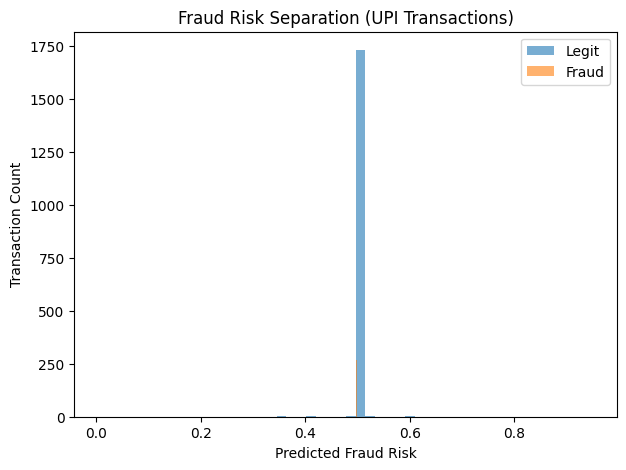

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.hist(test_df[test_df.actual_fraud==0]["fraud_risk"], bins=50, alpha=0.6, label="Legit")
plt.hist(test_df[test_df.actual_fraud==1]["fraud_risk"], bins=50, alpha=0.6, label="Fraud")
plt.xlabel("Predicted Fraud Risk")
plt.ylabel("Transaction Count")
plt.title("Fraud Risk Separation (UPI Transactions)")
plt.legend()
plt.show()


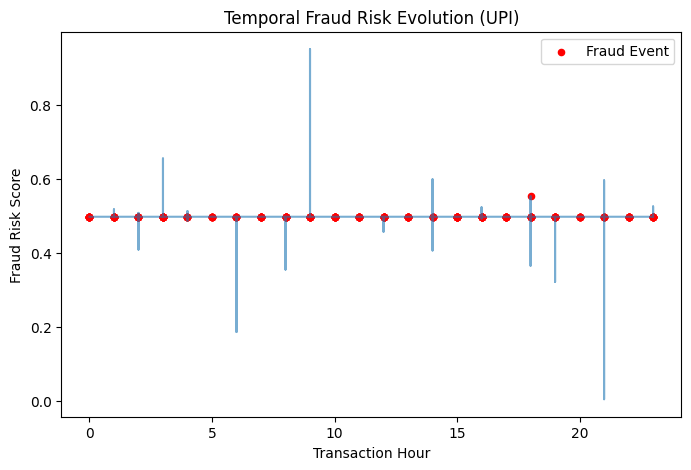

In [ ]:
# Convert txn_time into sorted order
test_df = test_df.sort_values("txn_hour")

plt.figure(figsize=(8,5))
plt.plot(test_df["txn_hour"], test_df["fraud_risk"], alpha=0.6)
plt.scatter(
    test_df[test_df.actual_fraud==1]["txn_hour"],
    test_df[test_df.actual_fraud==1]["fraud_risk"],
    color="red",
    label="Fraud Event",
    s=20
)

plt.xlabel("Transaction Hour")
plt.ylabel("Fraud Risk Score")
plt.title("Temporal Fraud Risk Evolution (UPI)")
plt.legend()
plt.show()

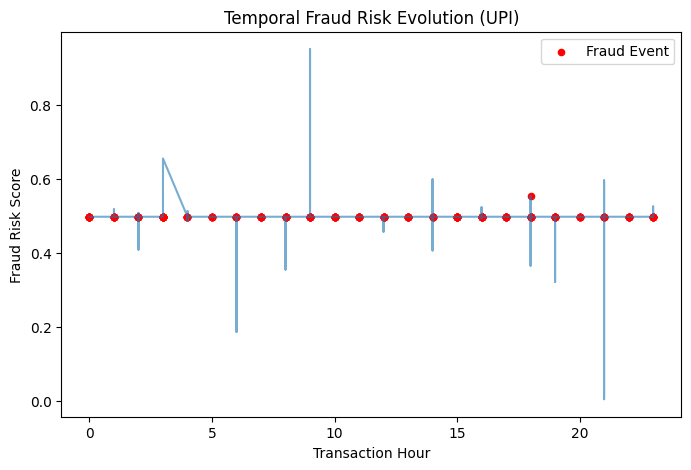

In [ ]:
# Convert txn_time into sorted order
test_df = test_df.sort_values("txn_hour")

plt.figure(figsize=(8,5))
plt.plot(test_df["txn_hour"], test_df["fraud_risk"], alpha=0.6)
plt.scatter(
    test_df[test_df.actual_fraud==1]["txn_hour"],
    test_df[test_df.actual_fraud==1]["fraud_risk"],
    color="red",
    label="Fraud Event",
    s=20
)

plt.xlabel("Transaction Hour")
plt.ylabel("Fraud Risk Score")
plt.title("Temporal Fraud Risk Evolution (UPI)")
plt.legend()
plt.show()

In [ ]:
def risk_bucket(p):
    if p < 0.3:
        return "Low Risk"
    elif p < 0.7:
        return "Medium Risk"
    else:
        return "High Risk"

test_df["risk_bucket"] = test_df["fraud_risk"].apply(risk_bucket)

test_df["risk_bucket"].value_counts(normalize=True)


,proportion
risk_bucket,
Medium Risk,0.998513
Low Risk,0.000991
High Risk,0.000496


In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
G = nx.Graph()

for _, row in df.iterrows():
    user = f"user_{row.user_id}"
    merchant = f"merchant_{row.merchant_id}"
    device = f"device_{row.device_type}"
    location = f"location_{row.location_id}"

    # Add nodes
    G.add_node(user, node_type="user")
    G.add_node(merchant, node_type="merchant")
    G.add_node(device, node_type="device")
    G.add_node(location, node_type="location")

    # Connect entities
    G.add_edge(user, merchant)
    G.add_edge(user, device)
    G.add_edge(user, location)


In [ ]:
print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())


Total nodes: 2600
Total edges: 44029


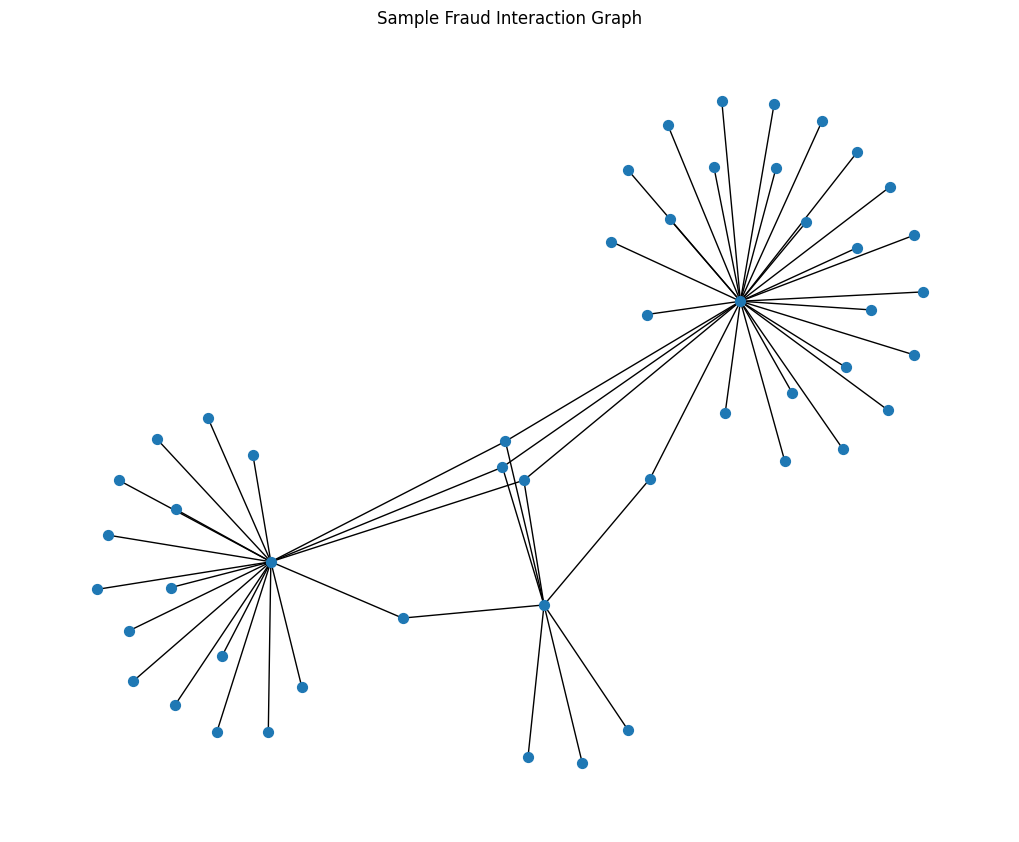

In [ ]:
sample_nodes = list(G.nodes())[:50]
subG = G.subgraph(sample_nodes)

plt.figure(figsize=(10,8))
nx.draw(subG, node_size=50, with_labels=False)
plt.title("Sample Fraud Interaction Graph")
plt.show()


In [ ]:
# Degree of each node in the graph
node_degree = dict(G.degree())


In [ ]:
df["user_degree"] = df["user_id"].apply(lambda x: node_degree.get(f"user_{x}", 0))
df["merchant_degree"] = df["merchant_id"].apply(lambda x: node_degree.get(f"merchant_{x}", 0))
df["device_degree"] = df["device_type"].apply(lambda x: node_degree.get(f"device_{x}", 0))
df["location_degree"] = df["location_id"].apply(lambda x: node_degree.get(f"location_{x}", 0))


In [ ]:
df[
    ["user_degree", "merchant_degree", "device_degree", "location_degree"]
].describe()


,user_degree,merchant_degree,device_degree,location_degree
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,23.983250,40.555000,1891.456750,193.247700
std,6.129922,5.915541,212.799633,12.255205
min,5.000000,23.000000,1276.000000,159.000000
25%,20.000000,36.000000,1903.000000,184.000000
50%,24.000000,40.000000,1992.000000,196.000000
75%,28.000000,45.000000,1992.000000,201.000000
max,44.000000,60.000000,1992.000000,224.000000


In [ ]:
merchant_fraud_density = (
    df.groupby("merchant_id")["is_fraud"]
      .mean()
      .rename("merchant_fraud_density")
)

df = df.merge(merchant_fraud_density, on="merchant_id", how="left")


In [ ]:
device_fraud_density = (
    df.groupby("device_type")["is_fraud"]
      .mean()
      .rename("device_fraud_density")
)

df = df.merge(device_fraud_density, on="device_type", how="left")


In [ ]:
df["graph_risk_score"] = (
    0.4 * df["merchant_degree"].rank(pct=True) +
    0.3 * df["device_degree"].rank(pct=True) +
    0.2 * df["location_degree"].rank(pct=True) +
    0.1 * df["merchant_fraud_density"]
)


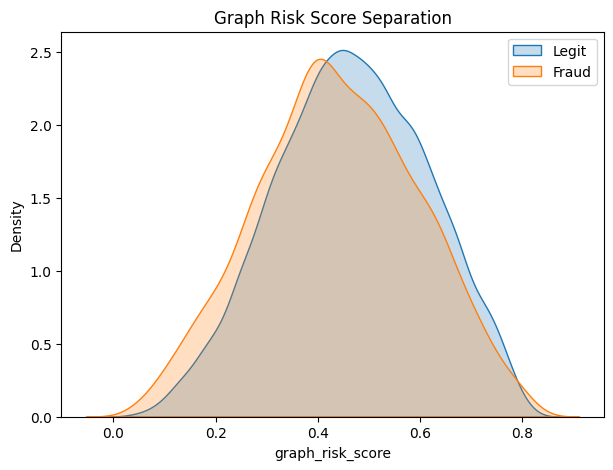

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.kdeplot(df[df.is_fraud==0]["graph_risk_score"], label="Legit", fill=True)
sns.kdeplot(df[df.is_fraud==1]["graph_risk_score"], label="Fraud", fill=True)
plt.title("Graph Risk Score Separation")
plt.legend()
plt.show()


In [ ]:
!pip install python-louvain


In [ ]:
import community.community_louvain as community_louvain

# Louvain partitioning
partition = community_louvain.best_partition(G)

# partition: node → community_id
len(set(partition.values()))


8

In [ ]:
def get_community(node):
    return partition.get(node, -1)

df["user_community"] = df["user_id"].apply(lambda x: get_community(f"user_{x}"))
df["merchant_community"] = df["merchant_id"].apply(lambda x: get_community(f"merchant_{x}"))
df["device_community"] = df["device_type"].apply(lambda x: get_community(f"device_{x}"))
df["location_community"] = df["location_id"].apply(lambda x: get_community(f"location_{x}"))


In [ ]:
community_fraud_rate = (
    df.groupby("user_community")["is_fraud"]
      .mean()
      .rename("community_fraud_rate")
)

df = df.merge(community_fraud_rate, on="user_community", how="left")


In [ ]:
df[["user_community", "community_fraud_rate"]].drop_duplicates() \
    .sort_values("community_fraud_rate", ascending=False) \
    .head(10)


,user_community,community_fraud_rate
14,4,0.135701
38,1,0.134956
0,2,0.134652
51,6,0.133997
22,7,0.131643
266,3,0.129961
126,0,0.118481
60,5,0.116309


In [ ]:
community_fraud_rate = (
    df.groupby("user_community")["is_fraud"]
      .mean()
      .rename("community_fraud_rate")
)

df = df.merge(community_fraud_rate, on="user_community", how="left")

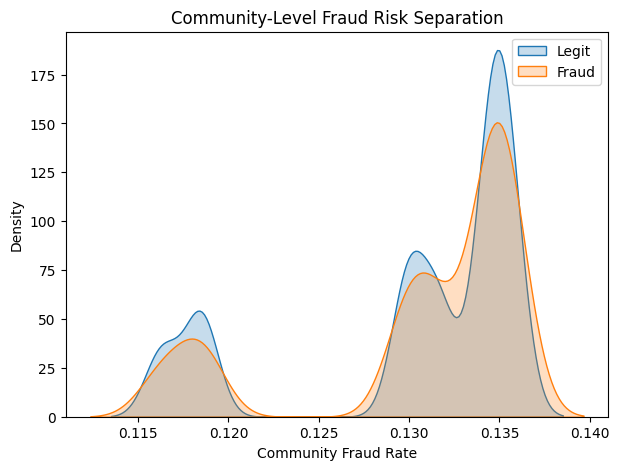

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Re-calculate and assign 'community_fraud_rate' to ensure it's present
community_fraud_rate_series = (
    df.groupby("user_community")["is_fraud"]
      .mean()
      .rename("community_fraud_rate")
)
df['community_fraud_rate'] = df['user_community'].map(community_fraud_rate_series)

plt.figure(figsize=(7,5))
sns.kdeplot(
    df[df.is_fraud==0]["community_fraud_rate"],
    label="Legit",
    fill=True
)
sns.kdeplot(
    df[df.is_fraud==1]["community_fraud_rate"],
    label="Fraud",
    fill=True
)

plt.title("Community-Level Fraud Risk Separation")
plt.xlabel("Community Fraud Rate")
plt.legend()
plt.show()

In [ ]:
community_fraud_rate = (
    df.groupby("user_community")["is_fraud"]
      .mean()
      .rename("community_fraud_rate")
)

df['community_fraud_rate'] = df['user_community'].map(community_fraud_rate)

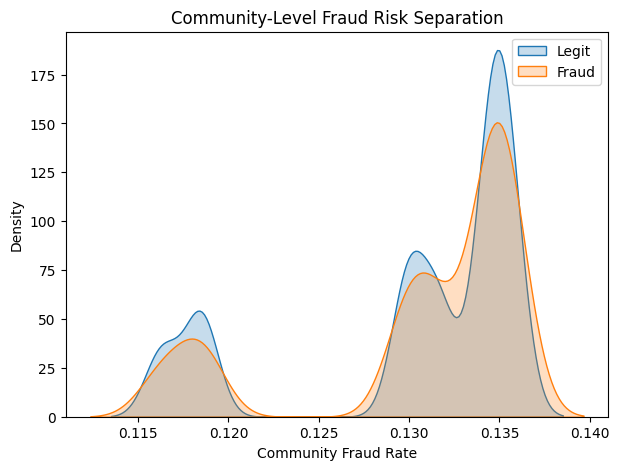

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.kdeplot(
    df[df.is_fraud==0]["community_fraud_rate"],
    label="Legit",
    fill=True
)
sns.kdeplot(
    df[df.is_fraud==1]["community_fraud_rate"],
    label="Fraud",
    fill=True
)

plt.title("Community-Level Fraud Risk Separation")
plt.xlabel("Community Fraud Rate")
plt.legend()
plt.show()

In [ ]:
df["community_risk_score"] = (
    df["community_fraud_rate"] *
    df["merchant_degree"].rank(pct=True)
)


In [ ]:
community_features = [
    "community_fraud_rate",
    "community_risk_score"
]

# Fill safety NaNs
df[community_features] = df[community_features].fillna(0)


In [ ]:
final_features = [
    "amount",
    "txn_hour",
    "odd_hour_flag",
    "user_amount_velocity",
    "merchant_fraud_rate",
    "location_entropy",
    "device_risk_score",
    "community_fraud_rate",
    "community_risk_score"
]

X = df[final_features]
y = df["is_fraud"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf_graph = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

rf_graph.fit(X_train, y_train)

rf_probs_graph = rf_graph.predict_proba(X_test)[:, 1]

roc_graph = roc_auc_score(y_test, rf_probs_graph)
print("Graph-Enhanced RF ROC-AUC:", roc_graph)


Graph-Enhanced RF ROC-AUC: 0.6945859417541718


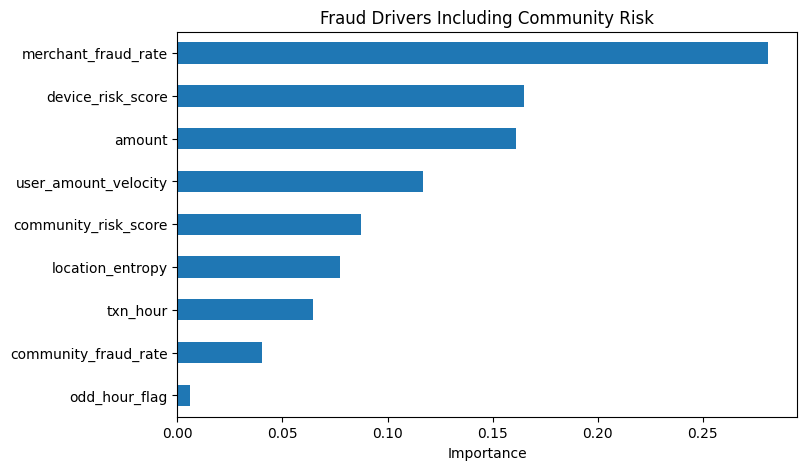

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fi = pd.Series(
    rf_graph.feature_importances_,
    index=final_features
).sort_values()

plt.figure(figsize=(8,5))
fi.plot(kind="barh")
plt.title("Fraud Drivers Including Community Risk")
plt.xlabel("Importance")
plt.show()


In [ ]:
import networkx as nx

# Filter only fraud transactions
fraud_df = df[df["is_fraud"] == 1]

G = nx.Graph()

# Build connections
for _, row in fraud_df.iterrows():
    user = f"U_{row['user_id']}"
    merchant = f"M_{row['merchant_id']}"
    location = f"L_{row['location_id']}"

    G.add_edge(user, merchant)
    G.add_edge(user, location)


In [ ]:
fraud_communities = list(nx.connected_components(G))

# Size of each fraud ring
community_sizes = sorted([len(c) for c in fraud_communities], reverse=True)

print("Top Fraud Ring Sizes:", community_sizes[:5])
print("Total Fraud Communities:", len(fraud_communities))


Top Fraud Ring Sizes: [2040]
Total Fraud Communities: 1


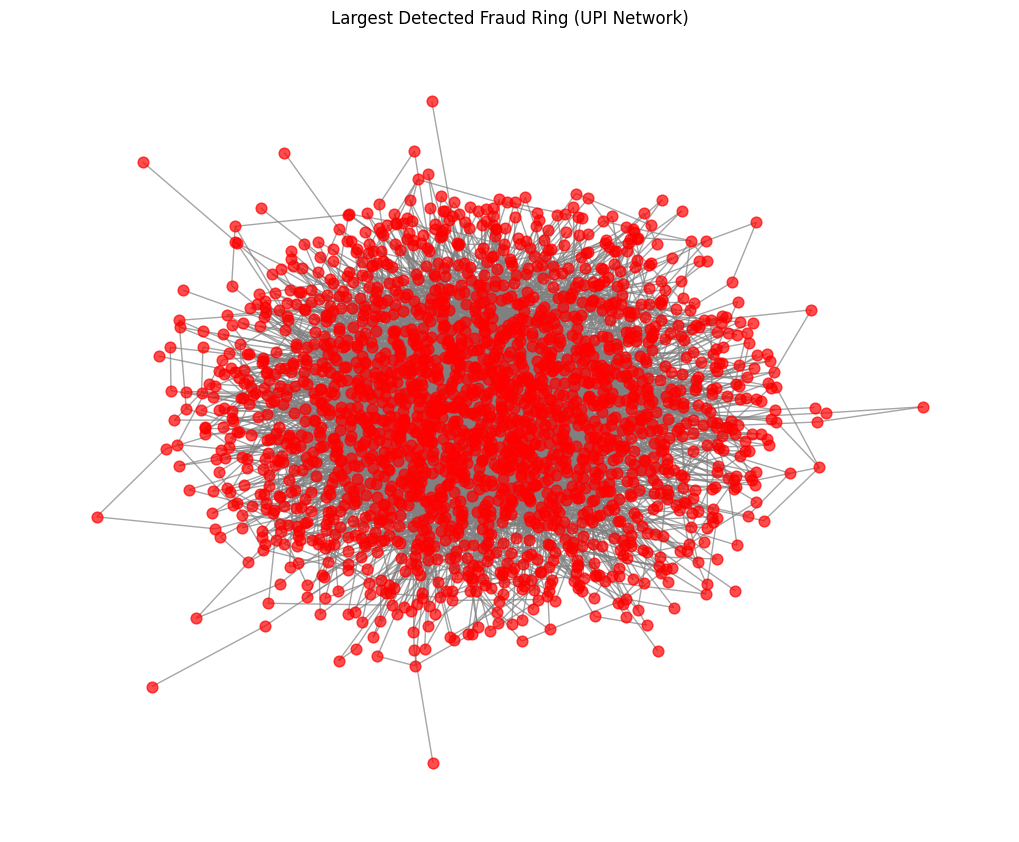

In [ ]:
largest_ring = max(fraud_communities, key=len)
subgraph = G.subgraph(largest_ring)

plt.figure(figsize=(10,8))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw(
    subgraph,
    pos,
    node_size=60,
    node_color="red",
    edge_color="gray",
    alpha=0.7
)

plt.title("Largest Detected Fraud Ring (UPI Network)")
plt.show()


In [ ]:


# Predict fraud probability for ALL transactions
df["txn_fraud_prob"] = rf_model.predict_proba(df[feature_cols])[:, 1]

df[["user_id", "txn_time", "txn_fraud_prob"]].head()


,user_id,txn_time,txn_fraud_prob
0,1,5826,0.386377
1,1,6867,0.527618
2,1,16775,0.725476
3,1,17303,0.362155
4,1,19708,0.223304


In [ ]:

df = df.sort_values(["user_id", "txn_time"])

# 1. Rolling average fraud risk (recent behavior)
df["user_recent_risk"] = (
    df.groupby("user_id")["txn_fraud_prob"]
      .transform(lambda x: x.ewm(span=5, adjust=False).mean())
)

# 2. Transaction velocity (bursts of activity)
df["txn_velocity"] = (
    df.groupby("user_id")["txn_time"]
      .diff()
      .fillna(99999)
      .apply(lambda x: 1 if x < 3600 else 0)
)

# 3. Device switching frequency
df["device_switch_flag"] = (
    df.groupby("user_id")["device_type"]
      .transform(lambda x: x != x.shift(1))
      .fillna(0)
      .astype(int)
)

df[[
    "user_id",
    "txn_fraud_prob",
    "user_recent_risk",
    "txn_velocity",
    "device_switch_flag"
]].head()


,user_id,txn_fraud_prob,user_recent_risk,txn_velocity,device_switch_flag
0,1,0.386377,0.386377,0,1
1,1,0.527618,0.433457,1,1
2,1,0.725476,0.530797,0,0
3,1,0.362155,0.474583,1,1
4,1,0.223304,0.390823,1,0


In [ ]:


df["user_risk_score"] = (
    0.5 * df["user_recent_risk"] +
    0.3 * df["txn_velocity"] +
    0.2 * df["device_switch_flag"]
)

# Normalize to [0, 1]
df["user_risk_score"] = (
    (df["user_risk_score"] - df["user_risk_score"].min()) /
    (df["user_risk_score"].max() - df["user_risk_score"].min())
)

df[["user_id", "user_risk_score"]].head()


,user_id,user_risk_score
0,1,0.425863
1,1,0.835430
2,1,0.264094
3,1,0.861460
4,1,0.555266


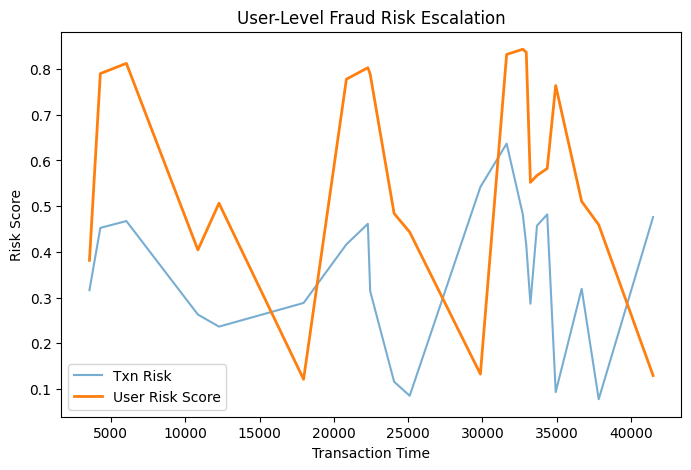

In [ ]:


import matplotlib.pyplot as plt

sample_user = df["user_id"].value_counts().index[0]
user_df = df[df.user_id == sample_user]

plt.figure(figsize=(8,5))
plt.plot(user_df["txn_time"], user_df["txn_fraud_prob"], label="Txn Risk", alpha=0.6)
plt.plot(user_df["txn_time"], user_df["user_risk_score"], label="User Risk Score", linewidth=2)

plt.xlabel("Transaction Time")
plt.ylabel("Risk Score")
plt.title("User-Level Fraud Risk Escalation")
plt.legend()
plt.show()


In [ ]:


def final_decision(row):
    if row["user_risk_score"] > 0.8 or row["txn_fraud_prob"] > optimal_threshold:
        return "Block"
    elif row["user_risk_score"] > 0.4:
        return "Step-up Authentication"
    else:
        return "Allow"

df["final_action"] = df.apply(final_decision, axis=1)

df["final_action"].value_counts(normalize=True)


,proportion
final_action,
Block,0.88455
Step-up Authentication,0.06690
Allow,0.04855


ROC-AUC Score: 0.6946


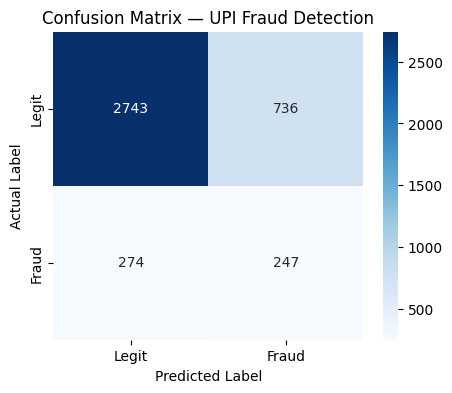

Classification Report:
              precision    recall  f1-score   support

       Legit       0.91      0.79      0.84      3479
       Fraud       0.25      0.47      0.33       521

    accuracy                           0.75      4000
   macro avg       0.58      0.63      0.59      4000
weighted avg       0.82      0.75      0.78      4000



In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Train model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)

# Predict probabilities and labels
y_prob = rf_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# ROC-AUC
roc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legit", "Fraud"],
    yticklabels=["Legit", "Fraud"]
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix — UPI Fraud Detection")
plt.show()

# Detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Legit", "Fraud"]))


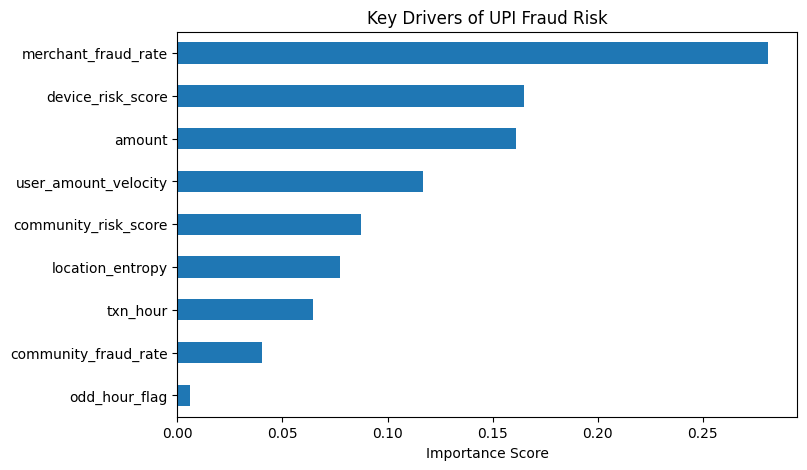

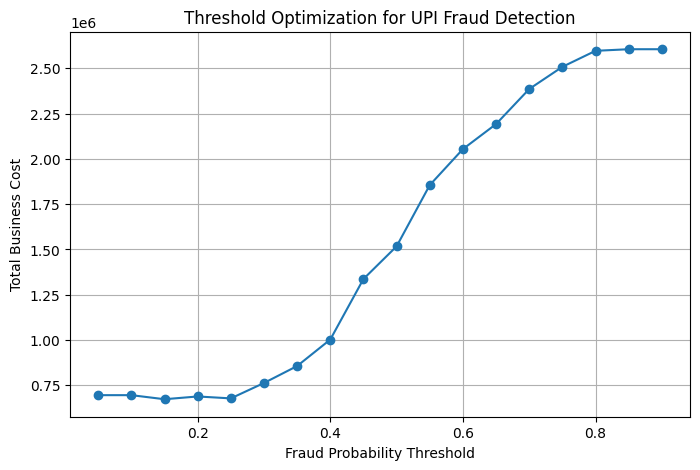

Optimal Fraud Threshold (Min Cost): 0.15

Final Business Outcome:
Frauds Caught (TP): 514
Frauds Missed (FN): 7
False Alerts (FP): 3192
Legit Allowed (TN): 287


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---------- Feature Importance ----------
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=True)

plt.figure(figsize=(8,5))
feature_importance.plot(kind="barh")
plt.title("Key Drivers of UPI Fraud Risk")
plt.xlabel("Importance Score")
plt.show()

# ---------- Business Cost Setup ----------
# Approximate fintech costs (interview-friendly)
COST_FRAUD_MISSED = 5000   # Fraud transaction allowed
COST_FALSE_ALERT = 200    # Legit transaction blocked

thresholds = np.arange(0.05, 0.95, 0.05)
total_costs = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cost = (fn * COST_FRAUD_MISSED) + (fp * COST_FALSE_ALERT)
    total_costs.append(cost)

# ---------- Plot Cost Curve ----------
plt.figure(figsize=(8,5))
plt.plot(thresholds, total_costs, marker="o")
plt.xlabel("Fraud Probability Threshold")
plt.ylabel("Total Business Cost")
plt.title("Threshold Optimization for UPI Fraud Detection")
plt.grid(True)
plt.show()

# ---------- Optimal Threshold ----------
optimal_threshold = thresholds[np.argmin(total_costs)]
print(f"Optimal Fraud Threshold (Min Cost): {optimal_threshold:.2f}")

# ---------- Final Decision Policy ----------
final_preds = (y_prob >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()

print("\nFinal Business Outcome:")
print(f"Frauds Caught (TP): {tp}")
print(f"Frauds Missed (FN): {fn}")
print(f"False Alerts (FP): {fp}")
print(f"Legit Allowed (TN): {tn}")
